# Task

Today is 2012-12-10. You are a Data Scientist at a large US publicly traded retailer.
Before the end of the year the Chief Financial Officer (CFO) needs to put out a financial
forecast for the coming calendar year (2013) to comply with regulations, and to
inform shareholders of expected business performance. You have been asked to
provide these forecasts. You have 1 week as people are going on Christmas holiday
on 2012-12-17, and the CFO wants some time to look over the forecasts and make
sure they are ok.
You have been provided with 3 files; features.csv, sales.csv, stores.csv, which contain
data about retail sales.

Tasks
* Analyse data, identify key drivers (features) for sales success (mandatory task).
* Prepare suggestions to CFO on how to improve sales for the next year (mandatory task).
* Predict next year's (2012-12-10 to 2013-12-10) weekly sales (task for bonus points).

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

In [2]:
features = pd.read_csv("/content/features.csv")
sales = pd.read_csv("/content/sales.csv")
stores = pd.read_csv("/content/stores.csv")

# Understanding Data

In [3]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [4]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [5]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [6]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [7]:
sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


In [8]:
sales.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,28/09/2012,508.37,False
421566,45,98,05/10/2012,628.10,False
421567,45,98,12/10/2012,1061.02,False
421568,45,98,19/10/2012,760.01,False
421569,45,98,26/10/2012,1076.80,False


In [9]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [10]:
print(features.shape)
print(sales.shape)
print(stores.shape)

(8190, 12)
(421570, 5)
(45, 3)


In [11]:
features['Date'] = pd.to_datetime(features['Date'])
sales['Date'] = pd.to_datetime(sales['Date'])

# EDA

In [12]:
df=pd.merge(sales,features, on=['Store','Date', 'IsHoliday'], how='left')
df=pd.merge(df,stores, on=['Store'], how='left')

df=df.fillna(0)
df['Temperature'] = (df['Temperature']- 32) * 5./9.

types_encoded, types =df['Type'].factorize()
df['Type'] = types_encoded

df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-05-02,24924.50,False,5.727778,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0,151315
1,1,1,2010-12-02,46039.49,True,3.616667,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,0,151315
2,1,1,2010-02-19,41595.55,False,4.405556,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,0,151315
3,1,1,2010-02-26,19403.54,False,8.127778,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,0,151315
4,1,1,2010-05-03,21827.90,False,8.055556,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,0,151315


In [13]:
print('training_data duplicated:{}'.format(df.duplicated().sum()))
df.drop_duplicates(inplace=True)

training_data duplicated:0


In [14]:
df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,15.605588,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,0.589912,136727.915739
std,12.785297,30.492054,22711.183519,10.248851,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,0.666337,60980.583328
min,1.000000,1.000000,-4988.940000,-18.922222,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,0.000000,34875.000000
25%,11.000000,18.000000,2079.650000,8.155556,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,0.000000,93638.000000
50%,22.000000,37.000000,7612.030000,16.716667,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,0.000000,140167.000000
75%,33.000000,74.000000,20205.852500,23.488889,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,1.000000,202505.000000
max,45.000000,99.000000,693099.360000,37.855556,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,2.000000,219622.000000


In [15]:
tab_info = pd.DataFrame(df.dtypes).T.rename(index={0:'column Type'}) 
tab_info = tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info = tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                                       rename(index={0: 'null values (%)'}))
tab_info

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
column Type,int64,int64,datetime64[ns],float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Analyzing data

In [16]:
# drop statistical outliers
constrains = df.select_dtypes(include=[np.number]) \
        .apply(lambda x: np.abs(stats.zscore(x)) < 3) \
        .all(axis=1)
df.drop(df.index[~constrains], inplace=True)

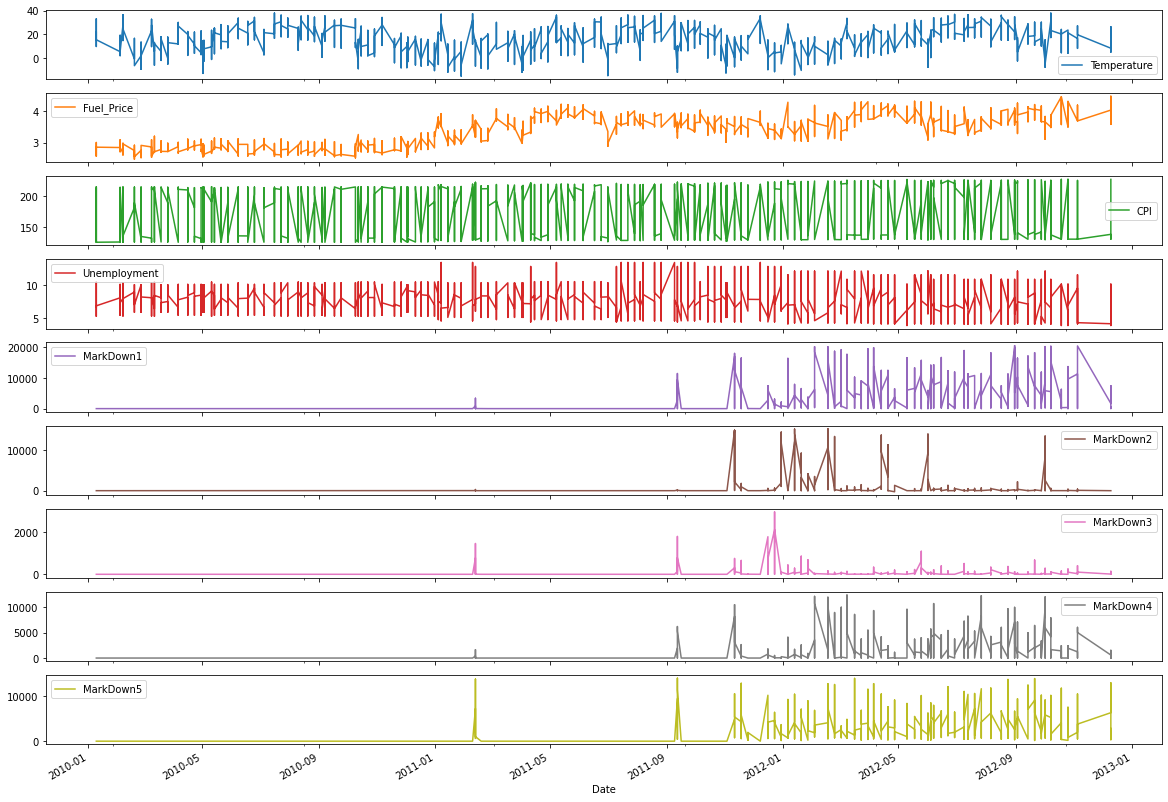

In [17]:
# a broad look at the data
df[['Date', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 
    'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].plot(x='Date', subplots=True, figsize=(20,15))
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  import sys


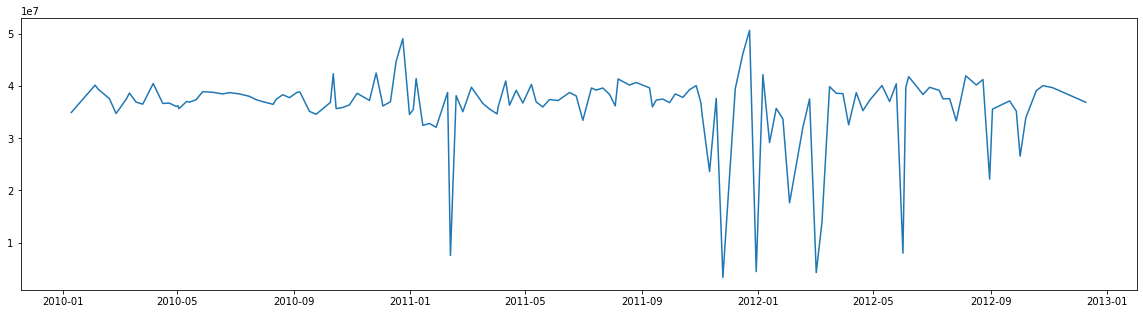

In [18]:
# looking at weekly sales by data
avg_sales_week = df.groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()
avg_sales = avg_sales_week.sort_values('Weekly_Sales', ascending=False)

plt.figure(figsize=(20,5))
plt.plot(avg_sales_week.Date, avg_sales_week.Weekly_Sales)
plt.locator_params(axis='x', nbins=5)
plt.show()

It can be seen that weekly sales spike during 3 periods in given years: 
Winter Holidays (Christmas, New Years)
Thanksgiving (US holiday)
Back to school period (where a lot of shopping is necessary to be done)

In [19]:
# most sales by date
avg_sales.head()

,Date,Weekly_Sales
98,2011-12-23,50706997.98
46,2010-12-24,49105484.95
97,2011-12-16,46245057.33
45,2010-12-17,44778558.39
41,2010-11-26,42526744.51


In [20]:
# least sales by date
avg_sales[::-1].head()

,Date,Weekly_Sales
95,2011-11-25,3312938.66
107,2012-03-02,4249232.91
99,2011-12-30,4438631.13
54,2011-02-12,7517102.44
119,2012-06-01,7978388.25


In [21]:
ts = avg_sales_week.set_index('Date')

In [22]:
top_stores = df.groupby(by=['Type'], as_index=False)['Weekly_Sales'].sum()
top_stores.sort_values('Weekly_Sales', ascending=False)

,Type,Weekly_Sales
0,0,3.117295e+09
1,1,1.688517e+09
2,2,3.641895e+08


In [23]:
top_stores = df.groupby(by=['Store'], as_index=False)['Weekly_Sales'].sum()
top_stores.sort_values('Weekly_Sales', ascending=False)[:10]

,Store,Weekly_Sales
3,4,2.000148e+08
12,13,1.841622e+08
19,20,1.831945e+08
5,6,1.818994e+08
1,2,1.805507e+08
9,10,1.795172e+08
22,23,1.793472e+08
10,11,1.765457e+08
26,27,1.758416e+08
13,14,1.701529e+08


In [24]:
data_stores = features.groupby("Store").agg({"Temperature":"mean","Fuel_Price":"mean","IsHoliday":"sum"})
temp_stores = sales.groupby("Store").agg({"Weekly_Sales":"sum"})
#temp_store.Weekly_Sales = temp_store.Weekly_Sales/1000000
#temp_store.Weekly_Sales = temp_store.Weekly_Sales.apply(int)
data_stores.set_index(np.arange(0,45),inplace=True)
stores["temp"] = data_stores.Temperature
stores["Fuel_Price"] = data_stores.Fuel_Price
stores["holiday"] = data_stores.IsHoliday
stores["Weekly_Sales"] = temp_stores.Weekly_Sales

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


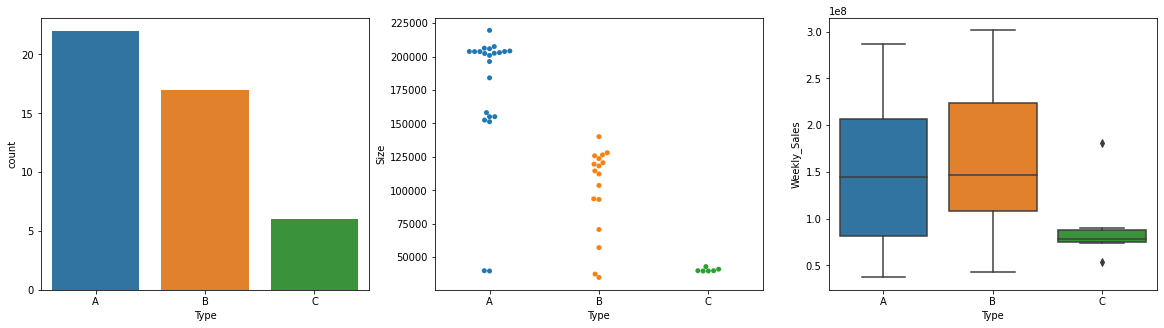

In [25]:
fig,ax = plt.subplots(1,3,figsize=(20, 5))
sns.countplot(stores.Type,ax=ax[0])
sns.swarmplot(data = stores,y="Size",x="Type",ax=ax[1])
sns.boxplot(data = stores,y="Weekly_Sales",x="Type",ax=ax[2])

Shows that while there are more stores of type A, type B stores have higher weekly sales.
Type B stores are also smaller, despite higher weekly sales.

In [26]:
depts = sales.groupby("Dept").agg({"Weekly_Sales":"sum"})
depts.sort_values(by="Weekly_Sales")

,Weekly_Sales
Dept,
47,-4.962930e+03
43,1.432000e+01
39,1.779800e+02
78,1.714710e+03
51,3.057283e+04
...,...
90,2.910685e+08
72,3.057252e+08
38,3.931181e+08


Text(0.5, 0, 'Department')

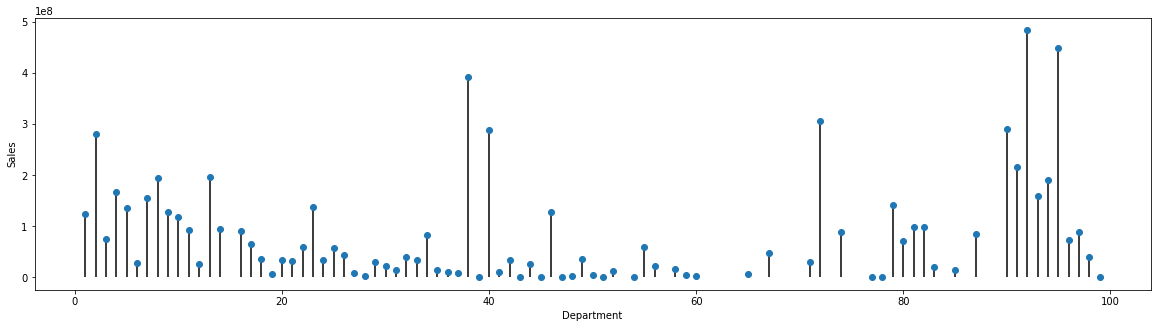

In [27]:
fig1, ax1 = plt.subplots(figsize=(20, 5))
plt.vlines(x=depts.index, ymin=0, ymax=depts['Weekly_Sales'])
plt.plot(depts.index,depts['Weekly_Sales'], "o")
plt.ylabel("Sales")
plt.xlabel("Department")

In [28]:
ordered = depts.sort_values(by='Weekly_Sales')

In [29]:
ordered[-20:]

,Weekly_Sales
Dept,
1,1.236388e+08
46,1.283444e+08
9,1.283933e+08
5,1.356074e+08
23,1.381803e+08
79,1.413965e+08
7,1.554776e+08
93,1.596987e+08
4,1.671467e+08


In [30]:
ordered[:20]

,Weekly_Sales
Dept,
47,-4962.93
43,14.32
39,177.98
78,1714.71
51,30572.83
45,44937.63
77,49344.27
99,358149.85
54,516294.63


Departments 1-15, 23, 38, 40, 46, 72, 90-95 are the highest perorming departments

Departments 39, 43, 47, 78 had close to 0 weekly sales
And were among other low performers ( 1 000 000 weekly sales)

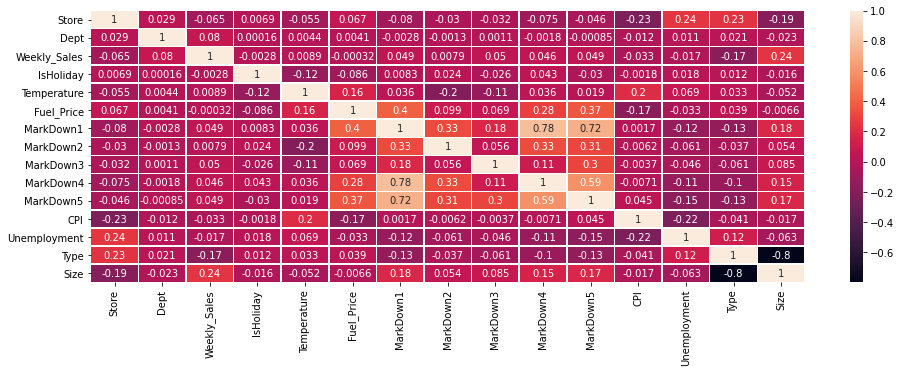

In [31]:
plt.figure(figsize = (16,5))
ax = sns.heatmap(df.corr(), annot=True, linewidths=.5)

The correlation heatmap shows that only the size of the store has the strongest correlation with weekly sales (Which also follow from simple logic: bigger store -> more products -> more customers -> more sales). Increasing the size of all stores is not a feasible way of increasing overall weekly sales.

Suggestions

*   Convert type A stores to type B or build more type B stores
*   Close down type C stores (assuming that, the current by far the lowest weekly sales by type are implying negative revenue)
*   Focus on the high performing deparments closing down the low performers (especially  39, 43, 47, 78 which 0 weekly sales)
* Target the 3 high sales velocity periods (Winter Holidays, Thanksgiving, Back-To-School period)

# Predicting 

In [32]:
date_store = sales.groupby(["Date","Store"]).agg({"Weekly_Sales":"sum"})
date_store.sort_index(inplace=True)
data_table = pd.merge(features,date_store ,  how='left', on=["Date","Store"])
data_table = pd.merge(data_table,stores[["Store","Type"]] , how='left', on=["Store"])

data_table['MarkDown1'].fillna((data_table['MarkDown1'].mean()), inplace=True)
data_table['MarkDown2'].fillna((data_table['MarkDown2'].mean()), inplace=True)
data_table['MarkDown3'].fillna((data_table['MarkDown3'].mean()), inplace=True)
data_table['MarkDown4'].fillna((data_table['MarkDown4'].mean()), inplace=True)
data_table['MarkDown5'].fillna((data_table['MarkDown5'].mean()), inplace=True)

data_table['Date'] = pd.to_datetime(data_table['Date'])

data_table['CPI'].fillna((data_table['CPI'].mean()), inplace=True)
data_table['Unemployment'].fillna((data_table['Unemployment'].mean()), inplace=True)
data_table['IsHoliday'] = data_table['IsHoliday'].astype('bool')
data_table['IsHoliday'] = data_table['IsHoliday'].map({True:0,False:1})

#create new column
data_table["Month"] = data_table.Date.dt.month
data_table["Year"] = data_table.Date.dt.year
data_table["WeekofYear"] = data_table.Date.dt.weekofyear
data_table.drop(['Date'],axis=1,inplace=True)

#create dummies out of categorical column

for col in ["Type","Month","Year","WeekofYear"]:
        one_hot = pd.get_dummies(data_table[col],prefix=col)
        data_table = data_table.join(one_hot)
        data_table.drop(col,axis = 1,inplace=True)

data_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8190 entries, 0 to 8189
Data columns (total 83 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Store          8190 non-null   int64  
 1   Temperature    8190 non-null   float64
 2   Fuel_Price     8190 non-null   float64
 3   MarkDown1      8190 non-null   float64
 4   MarkDown2      8190 non-null   float64
 5   MarkDown3      8190 non-null   float64
 6   MarkDown4      8190 non-null   float64
 7   MarkDown5      8190 non-null   float64
 8   CPI            8190 non-null   float64
 9   Unemployment   8190 non-null   float64
 10  IsHoliday      8190 non-null   int64  
 11  Weekly_Sales   6435 non-null   float64
 12  Type_A         8190 non-null   uint8  
 13  Type_B         8190 non-null   uint8  
 14  Type_C         8190 non-null   uint8  
 15  Month_1        8190 non-null   uint8  
 16  Month_2        8190 non-null   uint8  
 17  Month_3        8190 non-null   uint8  
 18  Month_4 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [33]:
data_table.head()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales,Type_A,Type_B,Type_C,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Year_2010,Year_2011,Year_2012,Year_2013,WeekofYear_1,WeekofYear_2,WeekofYear_3,WeekofYear_4,WeekofYear_5,WeekofYear_6,WeekofYear_7,WeekofYear_8,WeekofYear_9,...,WeekofYear_13,WeekofYear_14,WeekofYear_15,WeekofYear_16,WeekofYear_17,WeekofYear_18,WeekofYear_19,WeekofYear_20,WeekofYear_21,WeekofYear_22,WeekofYear_23,WeekofYear_24,WeekofYear_25,WeekofYear_26,WeekofYear_27,WeekofYear_28,WeekofYear_29,WeekofYear_30,WeekofYear_31,WeekofYear_32,WeekofYear_33,WeekofYear_34,WeekofYear_35,WeekofYear_36,WeekofYear_37,WeekofYear_38,WeekofYear_39,WeekofYear_40,WeekofYear_41,WeekofYear_42,WeekofYear_43,WeekofYear_44,WeekofYear_45,WeekofYear_46,WeekofYear_47,WeekofYear_48,WeekofYear_49,WeekofYear_50,WeekofYear_51,WeekofYear_52
0,1,42.31,2.572,7032.371786,3384.176594,1760.10018,3292.935886,4132.216422,211.096358,8.106,1,1643690.90,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,38.51,2.548,7032.371786,3384.176594,1760.10018,3292.935886,4132.216422,211.242170,8.106,0,1641957.44,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,39.93,2.514,7032.371786,3384.176594,1760.10018,3292.935886,4132.216422,211.289143,8.106,1,1611968.17,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,46.63,2.561,7032.371786,3384.176594,1760.10018,3292.935886,4132.216422,211.319643,8.106,1,1409727.59,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,46.50,2.625,7032.371786,3384.176594,1760.10018,3292.935886,4132.216422,211.350143,8.106,1,1554806.68,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
data_table.isna().any()

Store            False
Temperature      False
Fuel_Price       False
MarkDown1        False
MarkDown2        False
                 ...  
WeekofYear_48    False
WeekofYear_49    False
WeekofYear_50    False
WeekofYear_51    False
WeekofYear_52    False
Length: 83, dtype: bool

In [35]:
data_train = data_table[data_table.Weekly_Sales.notnull()]
data_test = data_table[data_table.Weekly_Sales.isnull()]

In [36]:
# set range to (2012-12-10 to 2013-12-10)
data_test = data_test[(data_test.Year_2012 == 1) | (data_test.Year_2013 == 1)]
data_test = data_test[((data_test.Year_2012 == 1) & ((data_test.WeekofYear_50  == 1) | (data_test.WeekofYear_51  == 1) | (data_test.WeekofYear_52  == 1))) | ((data_test.Year_2013 == 1) & ((data_test.WeekofYear_50  != 1) & (data_test.WeekofYear_51  != 1) & (data_test.WeekofYear_52 != 1))) ]

X = data_train.drop('Weekly_Sales', axis=1)
y = data_train['Weekly_Sales']
# 8-2 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [37]:
data_test

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales,Type_A,Type_B,Type_C,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Year_2010,Year_2011,Year_2012,Year_2013,WeekofYear_1,WeekofYear_2,WeekofYear_3,WeekofYear_4,WeekofYear_5,WeekofYear_6,WeekofYear_7,WeekofYear_8,WeekofYear_9,...,WeekofYear_13,WeekofYear_14,WeekofYear_15,WeekofYear_16,WeekofYear_17,WeekofYear_18,WeekofYear_19,WeekofYear_20,WeekofYear_21,WeekofYear_22,WeekofYear_23,WeekofYear_24,WeekofYear_25,WeekofYear_26,WeekofYear_27,WeekofYear_28,WeekofYear_29,WeekofYear_30,WeekofYear_31,WeekofYear_32,WeekofYear_33,WeekofYear_34,WeekofYear_35,WeekofYear_36,WeekofYear_37,WeekofYear_38,WeekofYear_39,WeekofYear_40,WeekofYear_41,WeekofYear_42,WeekofYear_43,WeekofYear_44,WeekofYear_45,WeekofYear_46,WeekofYear_47,WeekofYear_48,WeekofYear_49,WeekofYear_50,WeekofYear_51,WeekofYear_52
149,1,48.89,3.168,3504.83,3384.176594,73.26,1636.80,2779.60,223.719277,6.573000,1,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
150,1,56.02,3.098,8231.71,3384.176594,274.00,358.15,2834.02,223.839845,6.573000,1,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
151,1,44.79,3.108,12659.55,37101.130000,174.78,74.46,1208.86,223.960414,6.573000,0,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
152,1,41.73,3.161,1214.08,25366.330000,15.01,72.36,3940.02,224.080983,6.525000,1,NaN,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
153,1,50.32,3.243,6520.24,16134.600000,12.17,774.55,4001.25,224.201552,6.525000,1,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,76.05,3.639,4842.29,975.030000,3.00,2449.97,3169.69,172.460809,7.826821,1,NaN,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8186,45,77.50,3.614,9090.48,2268.580000,582.74,5797.47,1514.93,172.460809,7.826821,1,NaN,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8187,45,79.37,3.614,3789.94,1827.310000,85.72,744.84,2150.36,172.460809,7.826821,1,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8188,45,82.84,3.737,2961.49,1047.070000,204.19,363.00,1059.46,172.460809,7.826821,1,NaN,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
# keeping default hyperparameters
# regressors fit the problem best
classifiers = [
  LinearRegression(),
  LGBMRegressor(),
  XGBRegressor(),
  ElasticNet(),
  BayesianRidge(),
  ]

In [39]:
names = [
         "Linear Regression", 
         "LGBM Regressor", 
         "XGBoost Regressor", 
         "Elastic Net Regression", 
         "Bayesian Ridge Regression",
         ]

In [40]:
df = df.reset_index()

In [41]:
accs = []
for name, clf in zip (names, classifiers):
  print(name)
  clf.fit(X_train, y_train)
  preds = clf.predict(X_test)
  accs.append(clf.score(X_test, y_test))
  print(clf.score(X_test, y_test))

Linear Regression
0.5395987795095198
LGBM Regressor
0.9698497169940484
XGBoost Regressor
[23:42:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9334289487566085
Elastic Net Regression
0.41744585840345716
Bayesian Ridge Regression
0.09480405825754079


In [42]:
# todo: grid-search for LGBMRegressor parameters

In [43]:
# LGBM had the best score, so using it
model = LGBMRegressor()
model.fit(X_train, y_train)
data_test.drop(['Weekly_Sales'],axis=1, inplace=True)
predict = model.predict(data_test)

In [44]:
predict

array([1807454.19525519, 2379945.03721354, 1565390.41494574, ...,
        801767.58797827,  780119.89400024,  752940.80580388])

In [45]:
predict.shape

(1485,)

In [46]:
predict.sum()

1577773272.7105815